<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/homework/hw1/Tema_1_Skel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 1 - A taste for music
## Găsirea genului pentru piese

### Autori: 
* George Muraru
* Alexandru Sorici

## 1. Scopul temei



Tema are ca scop folosirea metodelor de clasificare studiate în cadrul cursului/laboratorului pentru a **determina genul muzical** al unor sample-uri audio dintr-un set de date.

Se dorește înțelegerea procedurii tipice de **prelucrare a unui set de date**, de **explorare a atributelor**, precum și efectuarea unei **analize comparative** a mai multor algoritmi de clasificare, evidențiând diferențele între ei prin metrici precum *acuratețe, precizie, regăsire (eng. recall)*. 

## 2. Set de date

Primul pas în orice problema de data science este încărcarea și "înțelegerea" datelor.

Setul de date utilizat poartă denumirea de Free Music Archive [[1]](#fma). 

Dataset-ul utilizat este "usor" modificat - va conține doar 4 genuri muzicale: *Rock*, *Hip-Hop*, *Folk* și *Electronic*.

Setul de date este deja echilibrat (eng. balanced) -- sunt câte 500 de piese din fiecare gen în setul de train și câte 100 în cel de testare.

Dacă setați parametrul [DOWNLOAD_SAMPLE_DATASET](#scrollTo=te02bqsfMhls) se va descărca și un audio sample pentru fiecare track_id atunci când se rulează celula specifică pentru secțiunea [Descărcare](#scrollTo=RxCYjmzTM82o).

Puteți asculta sample-ul din piesă [aici](#scrollTo=te02bqsfMhls).

Se va folosi drept **clasă** (eticheta care trebuie prezisa) *genul muzical cel mai general* (numele coloanei în engleza este *top_genre*) pentru fiecare piesă.


Setul de date conține pentru fiecare sample mai multe atribute (eng. features), de tip numeric, care pot fi folosite pentru clasificare. Acestea pot fi găsite în fișierele *features.csv* sau *echonest.csv*.


Pentru mai multe informații privind setul de date, se poate consulta [acest repository](https://github.com/mdeff/fma).

Dataset-ul utilizat este o copie ușor modificată a celor [3 dataset-uri](https://github.com/mdeff/fma#Data): *fma_small.zip*, *fma_medium.zip*, *fma_large.zip*.

## 3. Workspace Setup

### Parametrii

In [1]:
# Music samples -- has ~ 2GB
DOWNLOAD_SAMPLE_DATASET = True  #@param {type: "boolean"}

### Dependențe

In [2]:
'''
!pip install pandas --user # needed for loading the dataset
!pip install xgboost --user
!pip install sklearn --user

if DOWNLOAD_SAMPLE_DATASET:
    !pip install ffmpeg --user # Needed by librosa for mp3
    !pip install librosa --user
    !pip install tqdm --user # Progress bar for dowloading large file
'''

'\n!pip install pandas --user # needed for loading the dataset\n!pip install xgboost --user\n!pip install sklearn --user\n\nif DOWNLOAD_SAMPLE_DATASET:\n    !pip install ffmpeg --user # Needed by librosa for mp3\n    !pip install librosa --user\n    !pip install tqdm --user # Progress bar for dowloading large file\n'

### Import biblioteci

In [3]:
if DOWNLOAD_SAMPLE_DATASET:
    from tqdm import tqdm
    import librosa

import pandas as pd
from zipfile import ZipFile

import IPython.display as ipd

### Funcții ajutătoare

In [4]:
def _reporthook(t):
    """ ``reporthook`` to use with ``urllib.request`` that prints the process of the download.

    Uses ``tqdm`` for progress bar.

    **Reference:**
    https://github.com/tqdm/tqdm

    Args:
        t (tqdm.tqdm) Progress bar.
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """
        Args:
            b (int, optional): Number of blocks just transferred [default: 1].
            bsize (int, optional): Size of each block (in tqdm units) [default: 1].
            tsize (int, optional): Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

def getHomeworkArchives():
    """ Checks if the homework dataset is present in the local directory, if not,
    downloads it.
    """
    from os import path

    dataset_info = {
        "fma_song_info.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_info.zip",
        "fma_song_samples.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_samples.zip"
        # Need to upload this
    }

    for dataset_file, dataset_url in dataset_info.items():
        if not path.isfile(dataset_file):
            import urllib
            with tqdm(unit='B', unit_scale=True, miniters=1, desc=dataset_file) as t:
                urllib.request.urlretrieve(dataset_url, filename=dataset_file, reporthook=_reporthook(t))

            assert(path.isfile(dataset_file))

            with ZipFile(dataset_file, 'r') as zip_ref:
                zip_ref.extractall()
        else:
            print(f"{dataset_file} already in the local directory")


# ALL THE FUCTIONS FROM THIS POINT FORWARD ARE NEEDED ONLY IF
# DOWNLOAD_SAMPLE_DATASET IS TRUE
def load_tracks():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/tracks.csv"), index_col=0, header=[0,1])


def load_features():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open('song_info/features.csv'), index_col=0, header=[0,1,2])


def load_echonest():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/echonest.csv"), index_col=0, header=[0,1,2])


def get_song_path(track_id: int):
    ''' Given a track id return the path to the sample

    Args:
        track_id (int): the id for a song found the dataset

    Returns:
        The path to the sample relative to the current directory
    '''

    return f'song_samples/{track_id:06}.mp3'

### Descărcare

In [5]:
getHomeworkArchives()

fma_song_info.zip already in the local directory
fma_song_samples.zip already in the local directory


### Încărcare date

In [6]:
# Load Echonest features for our dataset
echonest = load_echonest()
tracks = load_tracks()
features = load_features()

# True/False masks for selecting training/test
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'].isin(['test', 'validation'])

# Get X and Y
X_train = echonest.loc[train, ('echonest', 'audio_features')]
X_test = echonest.loc[test, ('echonest', 'audio_features')]

Y_train = tracks.loc[train, ('track', 'genre_top')]
Y_test = tracks.loc[test, ('track', 'genre_top')]

X_total = echonest[('echonest', 'audio_features')]
Y_total = tracks[('track', 'genre_top')]

labels_music = ["Rock", "Hip-Hop", "Folk", "Electronic"]

## 4. Problemă de rezolvat



Împărțim problema de rezolvat a acestei teme în două subpuncte principale:
  * Implementarea unui clasificator al genului muzical (eng. genre) pentru un anumit sample de piesă prin intermediul a patru algoritmi (KMeans, Decision Trees/Random Forest, XGBoost și SVM). Construirea unei variante de baza (eng. baseline) a clasificatorului pentru fiecare algoritm propus.
  * Explorarea metodelor prin care pot fi îmbunătățite rezultatele fiecarui algoritm în parte (e.g. varierea atributelor, prelucrarea suplimentară a atributelor, modificarea hiperparametrilor algoritmului), evaluarea comparativă intra- (i.e. față de baseline pentru același tip de algoritm) și inter-algoritm.

### 4.1. Implementare si rulare clasificatori [5pct]

Pentru acest task se vor rula mai mulți algoritmi pe setul de date și vor fi notate rezultatele obținute.

Veți crea câte un clasificator folosind fiecare din cei patru algoritmi din următoarea listă:
  * KMeans [1 pct]
  * Arbori de decizie, păduri aleatoare [1 pct]
  * XGBoost [1 pct]
  * SVM [1 pct]

**Observație 1:** Pentru KMeans, fiind **nesupervizat**, vom presupune că *nu* se știe că numărul de clustere este 4.

**Observație 2:** Algoritmii listați **nu** trebuie implementati de mana (nu obligatoriu). Este permisă utilizarea versiunilor din biblioteci cunoscute (a se vedea exemplele sugerate mai jos).


#### **Utilizarea setului de date**
În general, majoritatea seturilor de date sunt împărțite în:
* setul de antrenare (eng. training dataset) - se rulează algoritmul de învățare pe acest set (eng. fit the model)
* setul de validare (eng. validation dataset sau dev set) - se utilizează pentru modificarea hiperparametrilor algoritmului (eng. tunning the hyperparameters)
* setul de testare (eng. testing dataset sau holdout dataset) - se rulează pentru testarea finală a algoritmului.

În scheletul temei, testul de validare și de testare sunt concatenate.

#### **Implementare algoritmi**
Dezvoltați clasificatorii *baseline* pe baza fiecărui algoritm din cei listați mai sus. 
Utilizați implementările default din bibliotecile alese pentru a obține baseline-ul.
Folosiți drept features *audio_features* din tabela de *echonest* (sunt deja selectate în schelet).

Folosiți set-ul *train* pentru antrenare și *test* pentru testare.

#### **Evaluare** [1 pct]
Găsiți [aici](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) o listă cu metrici folosite, in general, pentru evaluarea algoritmilor de machine learning.

Pentru fiecare algoritm în parte, raportați **cel puțin** metricile de *accuracy*, *precision*, *recall*, *f-score* și *matricea de confuzie (eng. confusion matrix)*.

**Observații KMeans**
1. Având în vedere că KMeans nu este un algoritm supervizat, putem să combinăm cele 2 seturi de date (train + testare) pentru a face clusterizarea.
2. Faceți rescale *feature-urilor* astfel încât acestea să fie centrate în 0 cu o deviație standard de 1 - [standardizarea datelor](#scrollTo=-tkdMwB5S-as)
3. Rulați KMeans pe setul de antrenare utilizând un număr diferit de clustere (eg. 2, 3, 4, 5, 6).
4. Verificați utlizând metoda [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) care este numărul optim de clustere (puteți încerca și cu [elbow](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml) însă va trebui să creșteți lungmea intervalului de clustere).
5. Alegeți numărul optim de clustere și calculați **doar** *randIndex*.
6. [Opțional] Puteți analiza coordonatele centroizilor pentru a observa cum diferă genurile muzicale în funcție de *audio_features*. 
6. [Opțional] Puteți testa să vedeți că piesele din același cluster seamănă utilizând codul de [aici](#scrollTo=fS6s1c-gPyMN).

**Observații DecisionTree/RandomForest**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) din biblioteca scikit-learn. 

**Observații XGBoost**

Implementarea sugerată este cea din biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

**Observații SVM**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/svm.html) din biblioteca scikit-learn.

#### Imports

In [7]:
from sklearn.preprocessing import (
    StandardScaler, scale, MinMaxScaler
)
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    adjusted_rand_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    silhouette_samples, silhouette_score
)

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

#### Generic functions

In [8]:
metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro", "confusion_matrix"]

def train_test_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    return get_metrics(Y_test, Y_pred)

def get_metrics(Y_true, Y_pred):
    acc = accuracy_score(Y_true, Y_pred, labels_music)
    prec = precision_score(Y_true, Y_pred, labels_music, average="macro")
    rec = recall_score(Y_true, Y_pred, average="macro")
    f1 = f1_score(Y_true, Y_pred, average="macro")
    cm = confusion_matrix(Y_true, Y_pred, labels_music, normalize="true")
    return {
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "confusion_matrix": cm
    }

def plot_confusion_matrix(cm, cmap=plt.cm.Purples):
    disp = ConfusionMatrixDisplay(cm, labels_music)
    disp.plot(cmap=cmap)
    disp.ax_.set_title("Confusion Matrix")
    plt.show()

def print_output_draw_confusion_matrix(metrics, cmap):
    print("Accuracy:  {:5.4f}".format(metrics["accuracy"]))
    print("Precision: {:5.4f}".format(metrics["precision_macro"]))
    print("Recall:    {:5.4f}".format(metrics["recall_macro"]))
    print("F1-score:  {:5.4f}".format(metrics["f1_macro"]))
    plot_confusion_matrix(metrics["confusion_matrix"], cmap)

#### KMeans

In [9]:
def silhouette_analysis(X):
    font = {"size": 22}
    plt.rc("font", **font)
    
    range_n_clusters = range(2, 7)
    results = {}
    
    for idx, n_clusters in enumerate(range_n_clusters):
        fig, ax = plt.subplots()
        fig.set_size_inches(18, 13)
        
        # Initialize the clusterer with n_clusters value
        clusterer = KMeans(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)
        
        # The silhouette_score gives the average value for all the
        # samples. This gives a perspective into the density and
        # separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        results[silhouette_avg] = n_clusters
        print("n_clusters = {} -> average silhouette_score = {:6.4f}"
              .format(n_clusters, silhouette_avg))
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging
            # to cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
        
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color,
                             alpha=0.7)

            # Label the silhouette plots with their cluster numbers
            # at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        ax.set_title("Silhouette plot for {} clusters."
                     .format(n_clusters))
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all
        # the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        ax.set_xlim(xmin=-0.2, xmax=1.0)
        ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    plt.show()
    plt.rcdefaults()
    return results

def KMeans_with_params(clf, X_total, Y_total):
    Y_pred = clf.fit_predict(X_total, Y_total)
    return adjusted_rand_score(Y_total, Y_pred)

def evaluate_KMeans(score):
    print("RandIndex similarity: {:5.4f}".format(score))

    fig, ax = plt.subplots()
    new_cmap1 = LinearSegmentedColormap.from_list("", ["lime","tomato","lime"])
    arr = [np.arange(start=-1, stop=1, step=0.01)]
    im = ax.imshow(arr, new_cmap1, aspect=0.15,
                   extent=[-1, 1, -1, 1])
    ax.set_yticks([])
    ax.set_xlim(xmin=-1, xmax=1)
    ax.axvline(x=score, color="purple", linestyle="-", linewidth=2)
    ax.set_xlabel("Rand Index Codomain")
    plt.show()
    plt.rcdefaults()

n_clusters = 2 -> average silhouette_score = 0.1727
n_clusters = 3 -> average silhouette_score = 0.1723
n_clusters = 4 -> average silhouette_score = 0.1876
n_clusters = 5 -> average silhouette_score = 0.1796
n_clusters = 6 -> average silhouette_score = 0.1801


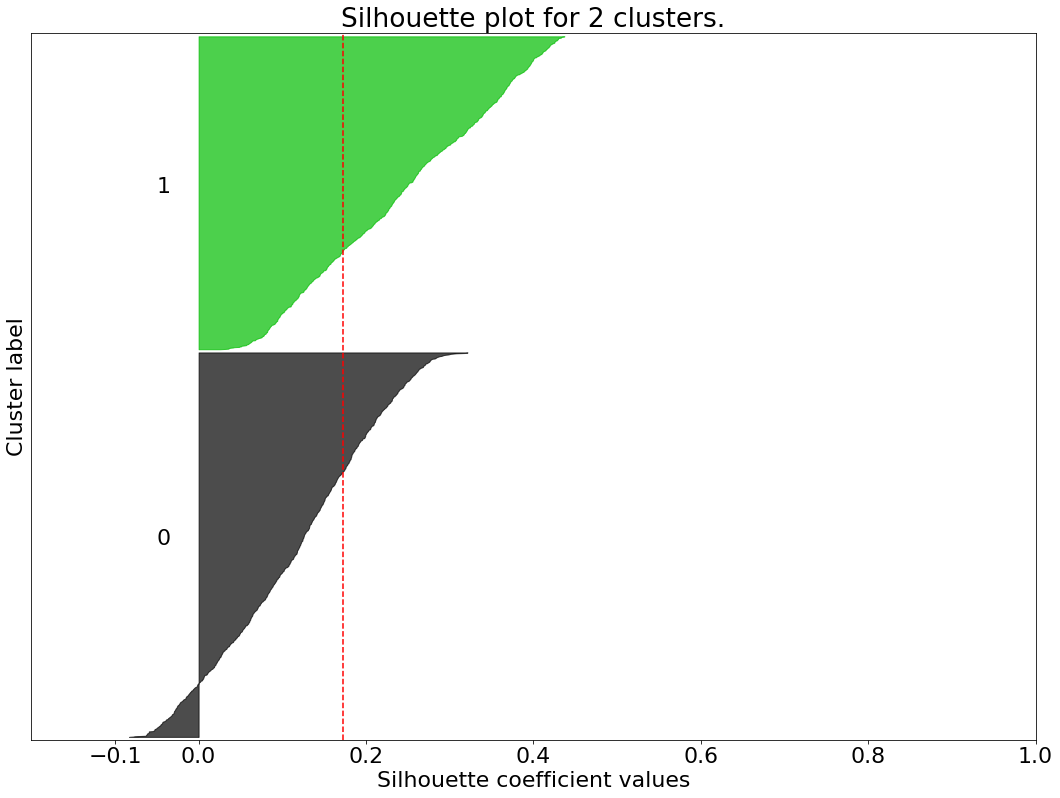

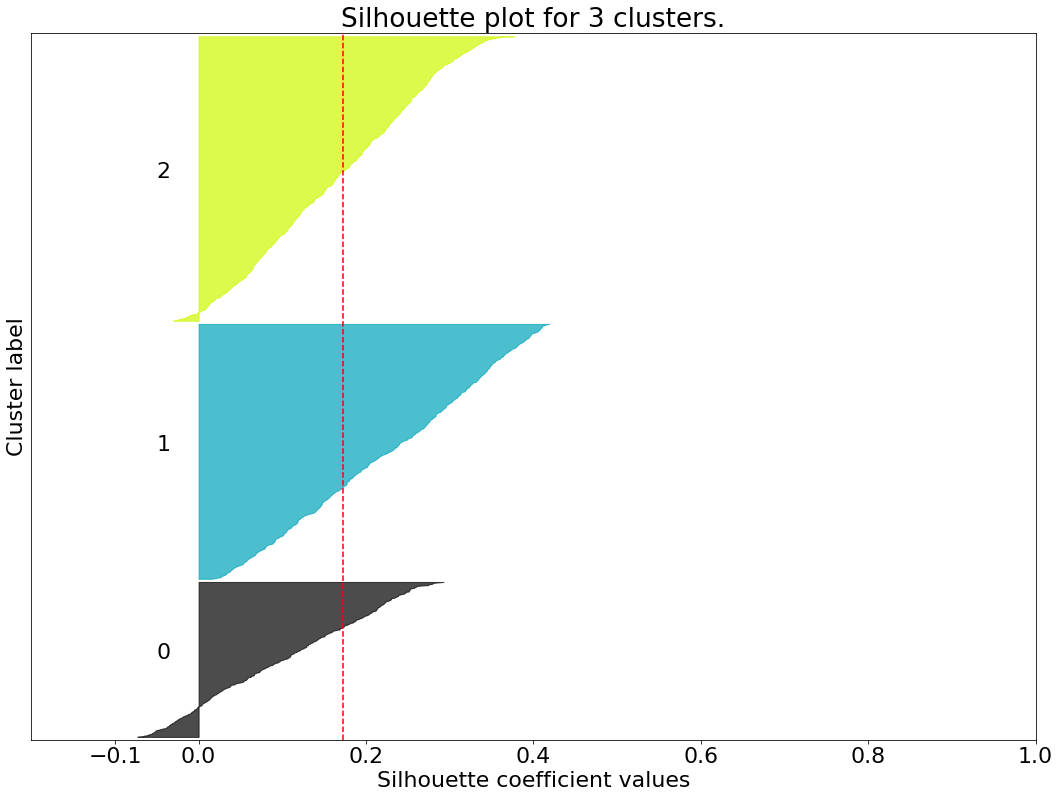

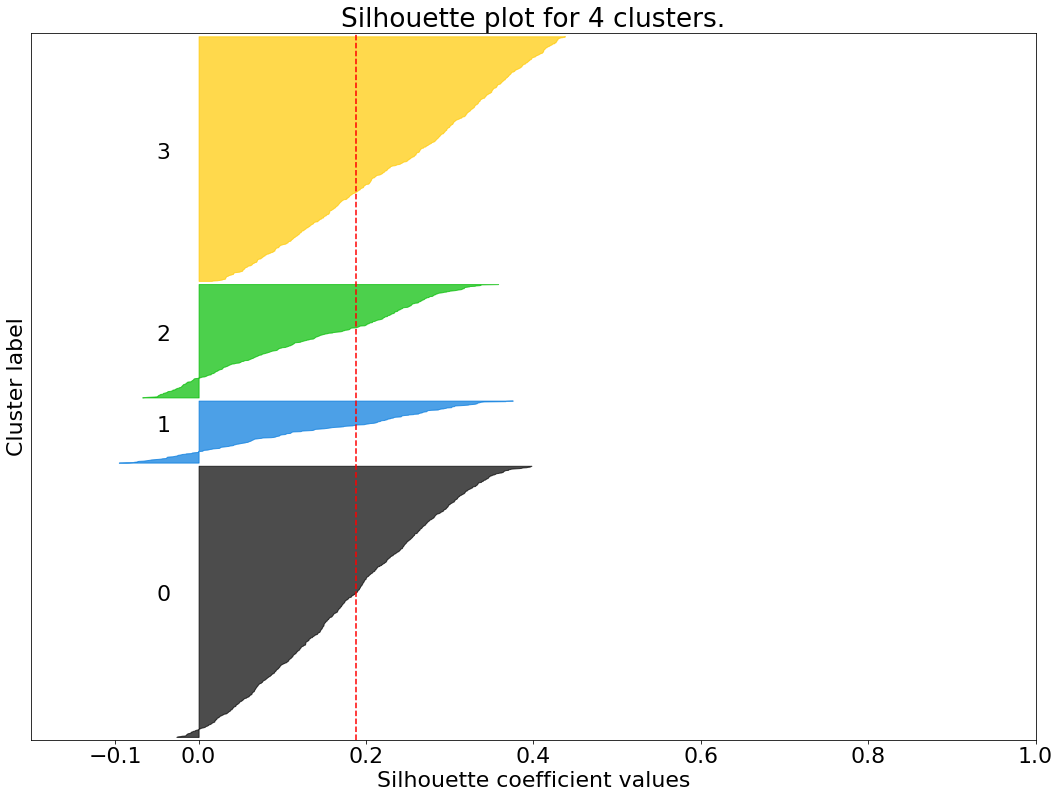

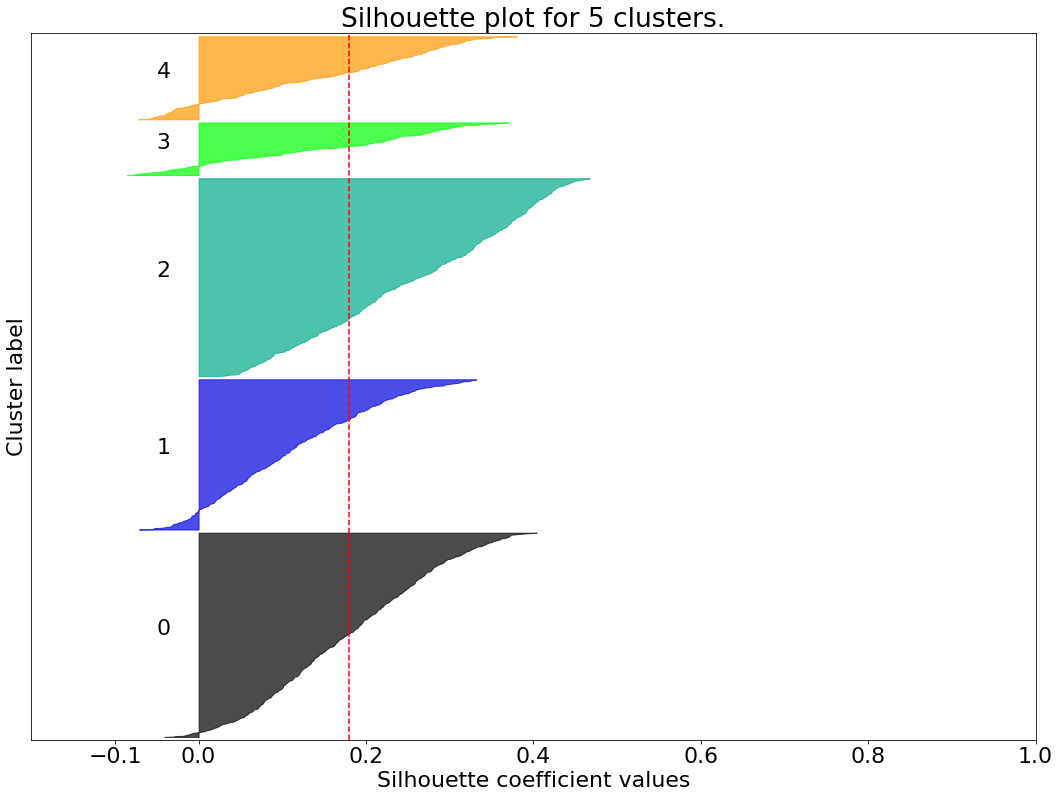

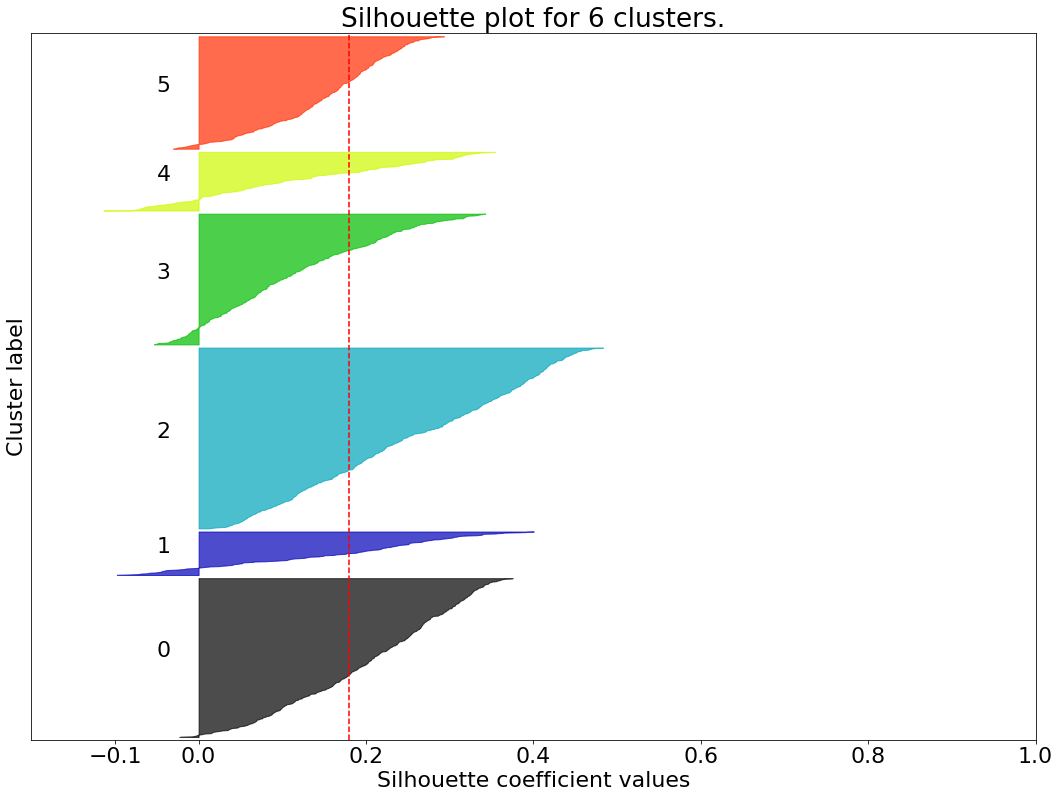

Best number of clusters: 4


In [10]:
scaler = StandardScaler()
X_total_scaled = scaler.fit_transform(X_total)

results = silhouette_analysis(X_total_scaled)
n_clusters = results[max(results.keys())]
print("Best number of clusters: {}".format(n_clusters))

RandIndex similarity: 0.2115


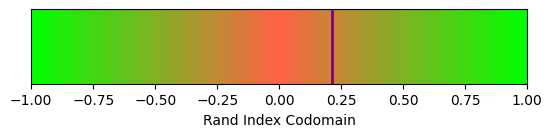

In [11]:
params_kmeans_base = {
    "n_clusters": n_clusters,
    "init": "k-means++", # k-means++ random
    "n_init": 10, # int > 1
    "tol": 1e-4, # float
    "precompute_distances": "auto", # boolean or auto
    "algorithm": "elkan", # auto full elkan
}
clf_kmeans_base = KMeans(**params_kmeans_base)
score_kmeans_base = KMeans_with_params(clf_kmeans_base, X_total_scaled, Y_total)
evaluate_KMeans(score_kmeans_base)

#### Random Forest

Accuracy:  0.7250
Precision: 0.7239
Recall:    0.7250
F1-score:  0.7223


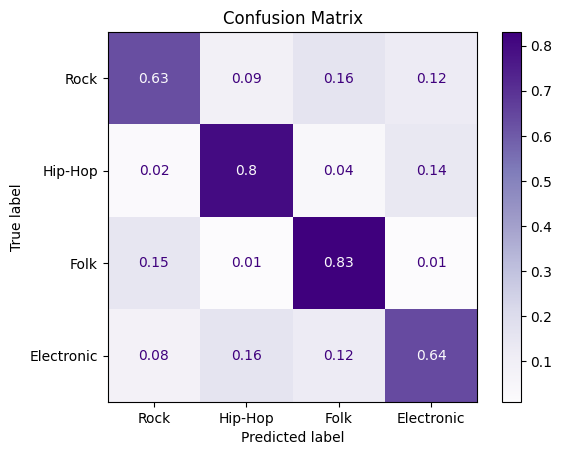

In [12]:
params_rf_base = {
    "n_estimators": 100, # int > 0
    "criterion": "gini", # gini entropy
    "max_depth": None, # int > 0
    "min_samples_split": 2, # int float
    "min_samples_leaf": 1, # int float
    "min_weight_fraction_leaf": 0.0, # float
    "max_features": "auto", # 
    "max_leaf_nodes": None, # int > 0 None
    "min_impurity_decrease": 0.0, # float > 0
    "bootstrap": True, # boolean
    "oob_score": False, # boolean
    "class_weight": None, # None, balanced, balanced_subsample
    "ccp_alpha": 0.0, # float >= 0
    "max_samples": None, # None int float
}
clf_rf_base = RandomForestClassifier(**params_rf_base)
metrics_rf_base = train_test_model(clf_rf_base, X_train, Y_train, X_test, Y_test)
print_output_draw_confusion_matrix(metrics_rf_base, plt.cm.Purples)

#### XGBoost

Accuracy:  0.7325
Precision: 0.7311
Recall:    0.7325
F1-score:  0.7305


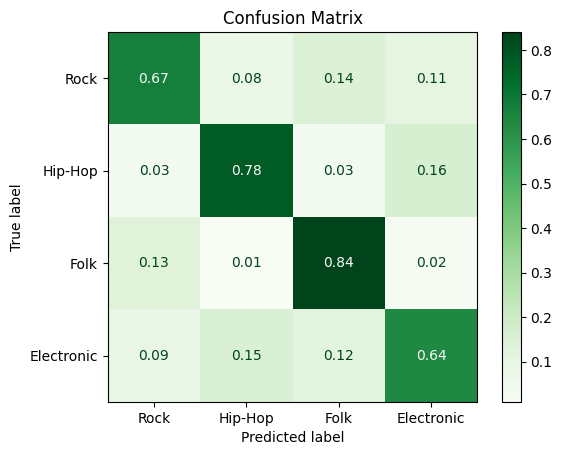

In [13]:
params_xgb_base = {
    "booster": "gbtree", # gbtree gblinear dart
    "learning_rate": 0.3, # float [0 - 1]
    "gamma": 0.0, # float >= 0
    "max_depth": 3, # int > 0
    "min_child_weight": 1, # int > 0
    "max_delta_step": 0, # int > 0
    "subsample": 1.0, # float (0, 1]
    "sampling_method": "uniform", # uniform gradient_based 
    "colsample_bytree": 1.0, # float (0, 1]
    "colsample_bylevel": 1.0, # float (0, 1]
    "colsample_bynode": 1.0, # float (0, 1]
    "reg_alpha": 0.0, # float
    "reg_lambda": 1.0, # float
    "tree_method": "auto", # auto exact approx hist
    "sketch_eps": 0.03, # float (0 - 1) only for approx
    "grow_policy": "depthwise", # depthwise lossguide only for hist 
}
clf_xgb_base = XGBClassifier(**params_xgb_base)
metrics_xgb_base = train_test_model(clf_xgb_base, X_train, Y_train, X_test, Y_test)
print_output_draw_confusion_matrix(metrics_xgb_base, plt.cm.Greens)

#### SVM

Accuracy:  0.2750
Precision: 0.2548
Recall:    0.2750
F1-score:  0.2426


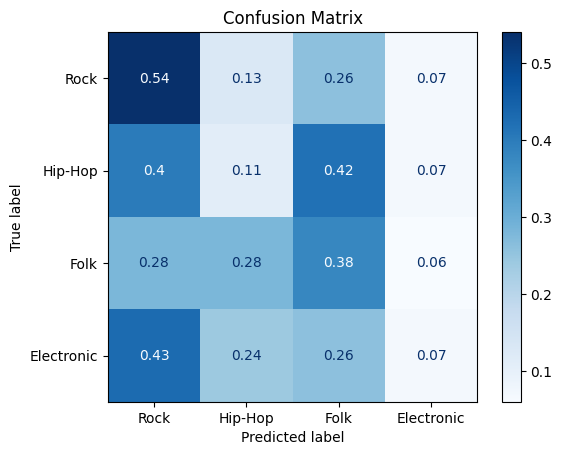

In [14]:
params_svm_base = {
    "C": 1.0,
    "kernel": "rbf",
    "degree": 3,
    "gamma": "scale",
    "coef0": 0.0,
    "shrinking": True,
    "probability": False,
    "tol": 0.001,
    "cache_size": 200,
    "class_weight": None,
    "decision_function_shape": "ovr",
    "break_ties": False
}
clf_svm_base = SVC(**params_svm_base)
metrics_svm_base = train_test_model(clf_svm_base, X_train, Y_train,X_test, Y_test)
print_output_draw_confusion_matrix(metrics_svm_base, plt.cm.Blues)

### 4.2. Metode de îmbunătățire și evaluare comparativă [5pct]

Pentru fiecare algoritm, explorați metode prin care să îmbunătățiți performanțele de la pasul precedent (cel de realizarea a baseline-ului).

**Îmbunătățire algoritmi** [3 pct]

Aveți în vedere următoarea listă de idei (și nu numai):
* adăugarea de mai multe feature-uri (momentan la baseline s-au folosit doar *audio_features*)
* [preprocesarea datelor](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) (eng. data preprocessing)
* [selectarea atributelor](https://scikit-learn.org/stable/modules/feature_selection.html) (eng. feature selection)
* modificarea hiperparametrilor fiecărui algoritm (e.g. tipul de kernel la SVM, coeficienți de regularizare, numărul de arbori în RandomForest, adâncimea arborilor în RandomForest)
    * **Atenție!**, exemplu de **AȘA NU**: rularea cu un număr maxim de 10 iterații la baseline și 100 de iterații la modelul mai bun.

În *fma_song_info.zip* există și un fișier *features.csv* -- detalii despre acesta se găsesc în repository-ul menționat în secțiunea [Set de date](#scrollTo=67UlrcAdqj3N).

In [15]:
scaler = StandardScaler()
X_total_scaled = X_total.copy()
X_total_scaled[list(X_total.columns)] = scaler.fit_transform(X_total)
X_train_scaled = X_total_scaled[train]
X_test_scaled = X_total_scaled[test]

min_max_scaler = MinMaxScaler()
X_total_minmax = X_total.copy()
X_total_minmax[list(X_total.columns)] = min_max_scaler.fit_transform(X_total)
X_train_minmax = X_total_minmax[train]
X_test_minmax = X_total_minmax[test]

#### KMeans

RandIndex similarity: 0.2115


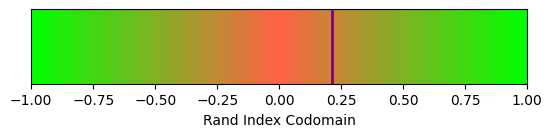

In [16]:
params_kmeans_enh = {
    "n_clusters": 4,
    "init": "k-means++", # k-means++ random
    "n_init": 10, # int > 1
    "tol": 1e-5, # float
    "precompute_distances": True, # boolean or auto
    "algorithm": "full", # auto full elkan
}
clf_kmeans_enh = KMeans(**params_kmeans_enh)
score_kmeans_enh = KMeans_with_params(clf_kmeans_enh, X_total_scaled, Y_total)
evaluate_KMeans(score_kmeans_enh)

#### Radom Forest

Accuracy:  0.7350
Precision: 0.7337
Recall:    0.7350
F1-score:  0.7322


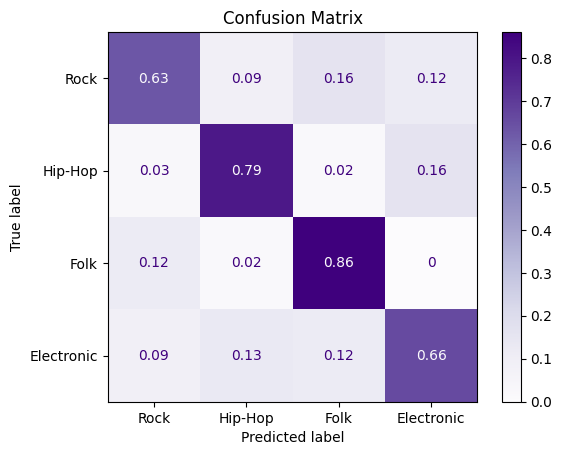

In [17]:
params_rf_enh = {
    "n_estimators": 100, # int > 0
    "criterion": "gini", # gini entropy
    "max_depth": 32, # int > 0
    "min_samples_split": 5, # int float
    "min_samples_leaf": 6, # int float
    "min_weight_fraction_leaf": 0.0, # float
    "max_features": "auto", # 
    "max_leaf_nodes": None, # int > 0 None
    "min_impurity_decrease": 0.0, # float > 0
    "bootstrap": True, # boolean
    "oob_score": True, # boolean
    "class_weight": "balanced", # None, balanced, balanced_subsample
    "ccp_alpha": 0.0, # float >= 0
    "max_samples": 0.8, # None int float
}
clf_rf_enh = RandomForestClassifier(**params_rf_enh)
metrics_rf_enh = train_test_model(clf_rf_enh, X_train_scaled, Y_train, X_test_scaled, Y_test)
print_output_draw_confusion_matrix(metrics_rf_enh, plt.cm.Purples)

#### XGBoost

Accuracy:  0.7425
Precision: 0.7428
Recall:    0.7425
F1-score:  0.7398


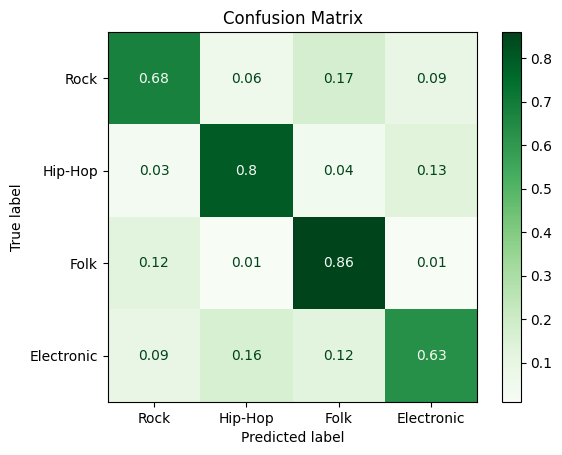

In [18]:
params_xgb_enh = {
    "booster": "dart", # gbtree gblinear dart
    "learning_rate": 0.3, # float [0 - 1]
    "gamma": 0.0, # float >= 0
    "max_depth": 3, # int > 0
    "min_child_weight": 1, # int > 0
    "max_delta_step": 0, # int > 0
    "subsample": 1.0, # float (0, 1]
    "sampling_method": "uniform", # uniform gradient_based 
    "colsample_bytree": 1.0, # float (0, 1]
    "colsample_bylevel": 1.0, # float (0, 1]
    "colsample_bynode": 1.0, # float (0, 1]
    "reg_alpha": 1.0, # float
    "reg_lambda": 1.0, # float
    "tree_method": "approx", # auto exact approx hist
    "sketch_eps": 0.03, # float (0 - 1) only for approx
    "grow_policy": "depthwise", # depthwise lossguide only for hist 
}
clf_xgb_enh = XGBClassifier(**params_xgb_enh)
metrics_xgb_enh = train_test_model(clf_xgb_enh, X_train, Y_train, X_test, Y_test)
print_output_draw_confusion_matrix(metrics_xgb_enh, plt.cm.Greens)

#### SVM

Accuracy:  0.7475
Precision: 0.7507
Recall:    0.7475
F1-score:  0.7441


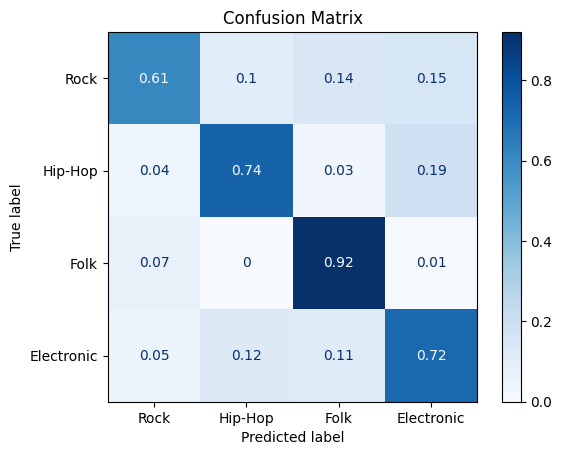

In [19]:
params_svm_enh = {
    "C": 1.2, # float > 0
    "kernel": "rbf", # linear, poly, rbf, sigmoid
    "degree": 3, # int, only for poly
    "gamma": "scale", # scale, auto, float
    "coef0": 0.0, # only for poly and sigmoid
    "shrinking": True, # boolean
    "probability": False, # boolean
    "tol": 0.1, # float
    "class_weight": "balanced", # dict, balanced
    "decision_function_shape": "ovr", # ovo, ovr
    "break_ties": False # boolean
}
clf_svm_enh = SVC(**params_svm_enh)
metrics_svm_enh = train_test_model(clf_svm_enh, X_train_minmax, Y_train, X_test_minmax, Y_test)
print_output_draw_confusion_matrix(metrics_svm_enh, plt.cm.Blues)

**Evaluare îmbunătățiri** [2 pct]

* Evaluați variantele îmbunătățite ale algoritmilor, folosind 5-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). Folosiți aceleași metrici ca în cazul baseline-ului.  **Atenție!** Pentru cross-validation trebuie să vă refaceti împartirea in train/test a setului de date.
* Realizați grafice în care să arătați analiza intra-algoritm a performanței îmbunătățirii (e.g. folosiți un bar chart pentru a compara accuracy-ul variantei baseline a RandomForest cu cea a variantei îmbunătățite).
* Realizați grafice în care să arătați analiza inter-algoritm a performanțelor. Faceți câte un grafic per metrică (e.g. accuracy, precision, recall) în care să încludeți valorile obținute de fiecare algoritm îmbunătățit în parte. 
* Redactați, pe seama graficelor, o analiză a acestora, evidențiind avantajele și dezavantajele fiecărui algoritm implementat.

In [20]:
from sklearn.model_selection import cross_val_predict

#### Radom Forest

Accuracy:  0.6763
Precision: 0.6759
Recall:    0.6763
F1-score:  0.6753


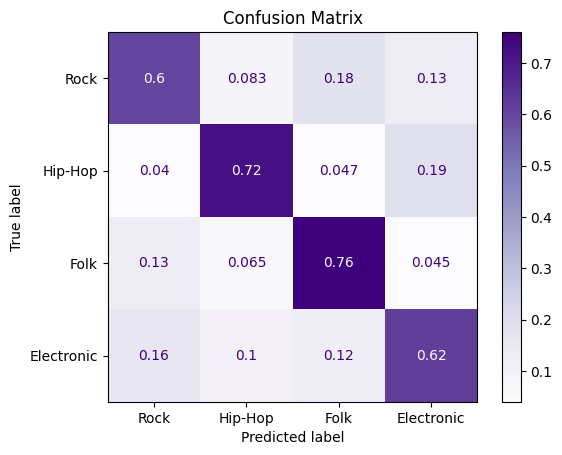

In [21]:
clf_rf_cross = RandomForestClassifier(**params_rf_enh)
Y_pred = cross_val_predict(clf_rf_cross, X_total_scaled, Y_total, cv=5)
metrics_rf_cross = get_metrics(Y_total, Y_pred)
print_output_draw_confusion_matrix(metrics_rf_cross, plt.cm.Purples)

#### XGBoost

Accuracy:  0.6646
Precision: 0.6644
Recall:    0.6646
F1-score:  0.6639


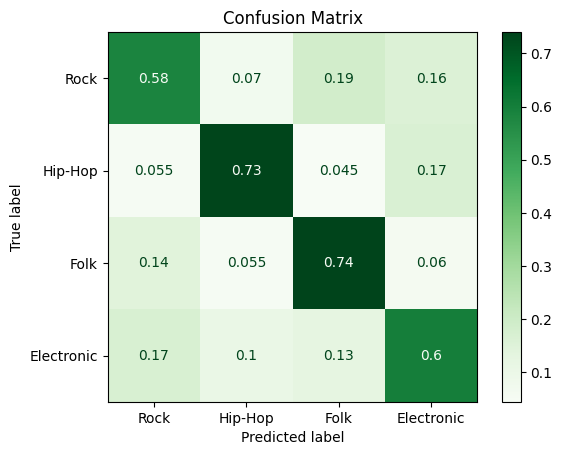

In [22]:
clf_xgb_cross = XGBClassifier(**params_xgb_enh)
Y_pred = cross_val_predict(clf_xgb_cross, X_total, Y_total, cv=5)
metrics_xgb_cross = get_metrics(Y_total, Y_pred)
print_output_draw_confusion_matrix(metrics_xgb_cross, plt.cm.Greens)

#### SVM

Accuracy:  0.6667
Precision: 0.6680
Recall:    0.6667
F1-score:  0.6651


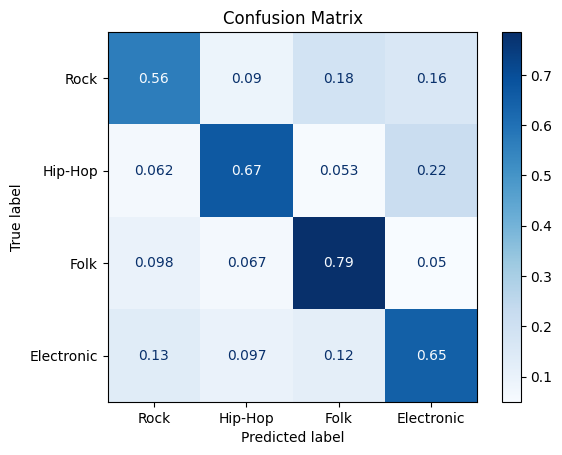

In [23]:
clf_svm_cross = SVC(**params_svm_enh)
Y_pred = cross_val_predict(clf_svm_cross, X_total_minmax, Y_total, cv=5)
metrics_svm_cross = get_metrics(Y_total, Y_pred)
print_output_draw_confusion_matrix(metrics_svm_cross, plt.cm.Blues)

In [24]:
def autolabel(rects):
    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'

        # If value of bar is negative: Place label left of bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label at right
            ha = 'right'

        # Use X value as label and format number with one decimal place
        label = "{:.4f}".format(x_value)

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha)                      # Horizontally align label differently for
                                        # positive and negative values.

#### KMeans

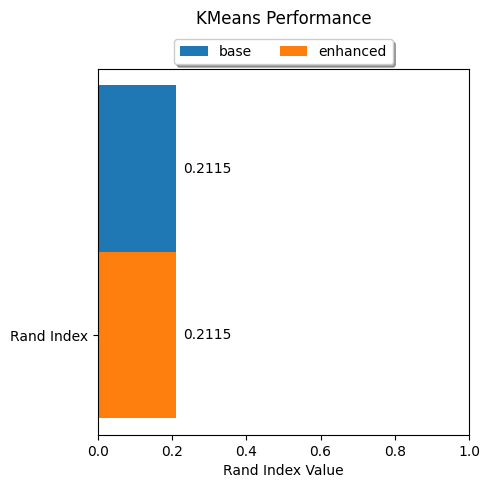

In [25]:
labels = ["Rand Index"]
base_values = [round(score_kmeans_base, 4)]
enh_values = [round(score_kmeans_enh, 4)]

x = np.arange(len(labels))  # the label locations
width = 0.02  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
rects1 = ax.barh(x +width, base_values, width, label="base")
rects2 = ax.barh(x , enh_values, width, label="enhanced")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('KMeans Performance', y = 1.1)
ax.set_xlabel('Rand Index Value')
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=3, fancybox=True, shadow=True)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#### Random forest

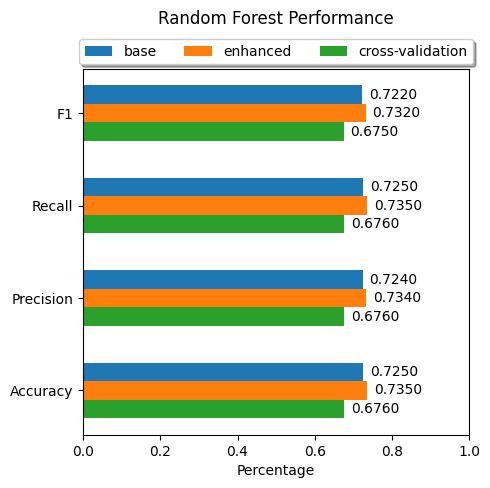

In [26]:
labels = ["Accuracy", "Precision", "Recall", "F1"]
keys = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
base_values = [round(_, 3) for _ in list(map(metrics_rf_base.get, keys))]
enh_values = [round(_, 3) for _ in list(map(metrics_rf_enh.get, keys))]
cross_values = [round(_, 3) for _ in list(map(metrics_rf_cross.get, keys))]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
rects1 = ax.barh(x + width, base_values, width, label="base")
rects2 = ax.barh(x , enh_values, width, label="enhanced")
rects3 = ax.barh(x - width, cross_values, width, label="cross-validation")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Random Forest Performance', y = 1.1)
ax.set_xlabel('Percentage')
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.10),
          ncol=3, fancybox=True, shadow=True)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

#### XGBoost

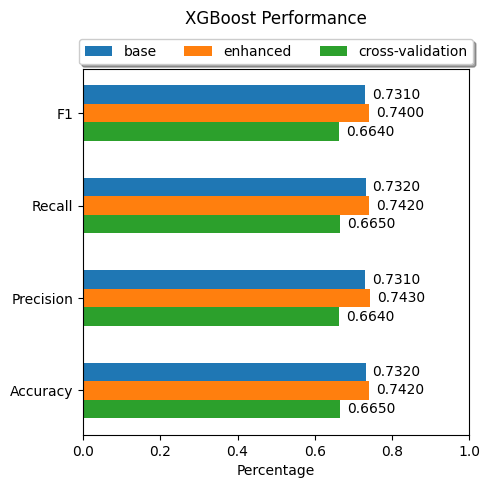

In [27]:
labels = ["Accuracy", "Precision", "Recall", "F1"]
keys = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
base_values = [round(_, 3) for _ in list(map(metrics_xgb_base.get, keys))]
enh_values = [round(_, 3) for _ in list(map(metrics_xgb_enh.get, keys))]
cross_values = [round(_, 3) for _ in list(map(metrics_xgb_cross.get, keys))]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
rects1 = ax.barh(x + width, base_values, width, label="base")
rects2 = ax.barh(x , enh_values, width, label="enhanced")
rects3 = ax.barh(x - width, cross_values, width, label="cross-validation")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('XGBoost Performance', y = 1.1)
ax.set_xlabel('Percentage')
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=3, fancybox=True, shadow=True)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

#### SVM

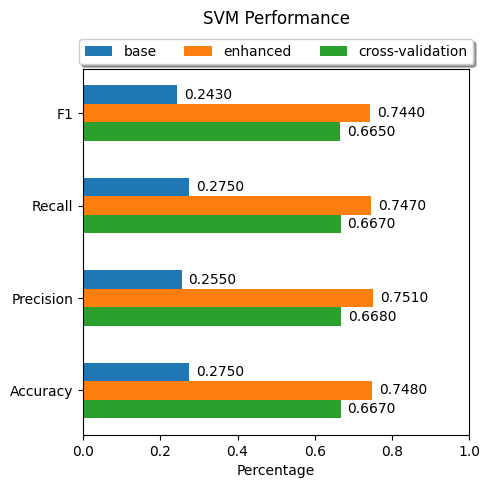

In [28]:
labels = ["Accuracy", "Precision", "Recall", "F1"]
keys = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
base_values = [round(_, 3) for _ in list(map(metrics_svm_base.get, keys))]
enh_values = [round(_, 3) for _ in list(map(metrics_svm_enh.get, keys))]
cross_values = [round(_, 3) for _ in list(map(metrics_svm_cross.get, keys))]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
rects1 = ax.barh(x + width, base_values, width, label="base")
rects2 = ax.barh(x , enh_values, width, label="enhanced")
rects3 = ax.barh(x - width, cross_values, width, label="cross-validation")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('SVM Performance', y = 1.1)
ax.set_xlabel('Percentage')
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=3, fancybox=True, shadow=True)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

## Analiză

5-fold cross-validation nu a adus o îmbunătățire asupra rezultatelor, de cele mai multe ori rezultatele au fost mai slabe decât modelul base. Ajustarea hiperparametrilor și scalarea datelor au adus îmbunătățiri substanțiale în rândul SVM-ului. În cazul celorlalte, îmbunătățirea nu este foarte semnificativă.
Scalarea datelor a fost utilă în cazul SVM-ului și algoritmului Random Forest.

## 5. Mențiuni

**Pentru rezolvarea task-urilor puteți folosi orice bibliotecă doriți.**

În scheletul temei, datele sunt încărcate folosind biblioteca [pandas](https://pandas.pydata.org/), însă puteți utiliza orice bibliotecă doriți.

**Algoritmii nu trebuie implementați de mână.**

"Rezolvarea" unei probleme de învățare automată se reduce la îmbunătățirea unei metrici.

Un prim pas important este reprezentat de crearea unui *baseline* sau a unei soluții banale, de start (eng. *vanilla solution*) și măsurarea acesteia.

Următorul pas îl reprezintă o serie de modificări aduse feature setului sau algoritmului de învățăre. Aceast pas reprezintă o iterație peste soluția inițială.

Tot procesul constă în aplicarea mai multor *iterații* până se ajunge la o valoare a metricii suficient de bună pentru problema de rezolvat. În cazul nostru, această valoare este reprezentată de ambiția fiecăruia dintre voi :)

**Recomandări**:
* biblioteca [sklearn](https://scikit-learn.org/) - oferă o colecție algoritmi de învățare automată, metrici, metode de selectare de caractaristici, etc.
* pentru XGBoost puteți folosit biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/)

## 6. Sample test
Biblioteca [librosa](https://librosa.github.io/librosa/) permite analizarea și redarea sunetelor.

Se poate folosi pentru a observa dacă anumite melodii găsite într-un anumit gen muzical sunt asemănătoare.

In [29]:
track_test = tracks[test].sample(1)
title = track_test[('track', 'title')].values[0]
genre = track_test[('track', 'genre_top')].values[0]
print(f"Song\n\ttitle: {title}\n\tgenre {genre}")

song_path = get_song_path(track_test.index.values[0])
song, rate = librosa.load(song_path)
ipd.Audio(song, rate=rate)

Song
	title: Smoke With A Hippie
	genre Hip-Hop


/home/vlad/.local/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


## 7. Link-uri utile
* [Evaluarea algoritmilor de clusterizare](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)
* [Standardizare vs Normalizare](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)

## Bibliografie
<a name="fma">[1] *Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, FMA: A Dataset For Music Analysis, 18th International Society for Music Information Retrieval Conference, 2017*</a>

